## Load and apply inference models
This notebook loads trained inference models from the outputs of `cmass.infer.train`, plots their prediction performance, and applies them to new test data.

In [92]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
from os.path import join
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('../../style.mcstyle')   # noqa
import numpy as np
import torch
import seaborn as sns
import pandas as pd
import warnings
from tqdm import tqdm

from tools import torch_device

device = torch_device()

# Suppress warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CUDA is not available. Using CPU.


## Load a model

In [93]:
wdir = '/anvil/scratch/x-mho1/cmass-ili'
cosmonames = [r'$\Omega_m$', r'$\Omega_b$', r'$h$', r'$n_s$', r'$\sigma_8$']
hodnames = [r'$\alpha$', r'$\log M_0$', r'$\log M_1$',
            r'$\log M_{\min}$', r'$\sigma_{\log M}$']
names = cosmonames  # +hodnames

# Specify model configuration
nbody = 'quijote'
sim = 'nonoise'
save_dir = join(wdir, nbody, sim, 'models')

# Specify data dtype
# tracer = 'halo'
tracer = 'galaxy'
summaries = ['nbar', 'zPk0', 'zPk2', 'zPk4',  'zQk0']
# summaries = ['Pk0', 'Pk2', 'Pk4', 'Qk0']
summary = '+'.join(summaries)
kmin, kmax = 0.0, 0.4
modelpath = join(save_dir, tracer, summary, f'kmin-{kmin}_kmax-{kmax}')
print(
    f'Loading model: nbody={nbody}, sim={sim}, tracer={tracer}, \n\tsummary={summary}, kmin={kmin}, kmax={kmax}')
print('\n'.join(os.listdir(modelpath)))

Loading model: nbody=quijote, sim=nonoise, tracer=galaxy, 
	summary=nbar+zPk0+zPk2+zPk4+zQk0, kmin=0.0, kmax=0.4
x_val.npy
posterior.pkl
true_logprobs.npy
ids_test.npy
plot_hyperparam_dependence.png
theta_train.npy
plot_coverage.jpg
theta_test.npy
x_test.npy
nets
plot_true_logprobs.jpg
ids_train.npy
theta_val.npy
ranks_histogram.jpg
plot_single_posterior.jpg
x_train.npy
plot_TARP.jpg
optuna_study.db
plot_predictions.jpg
ids_val.npy
posterior_samples.npy


In [94]:
# Load predictions
xtest = np.load(join(modelpath, 'x_test.npy'))
ytest = np.load(join(modelpath, 'theta_test.npy'))
samps = np.load(join(modelpath, 'posterior_samples.npy'))
percs = np.percentile(samps, [16, 50, 84], axis=0)

yrange = np.stack([
    ytest.min(axis=0),
    ytest.max(axis=0)
], axis=1)

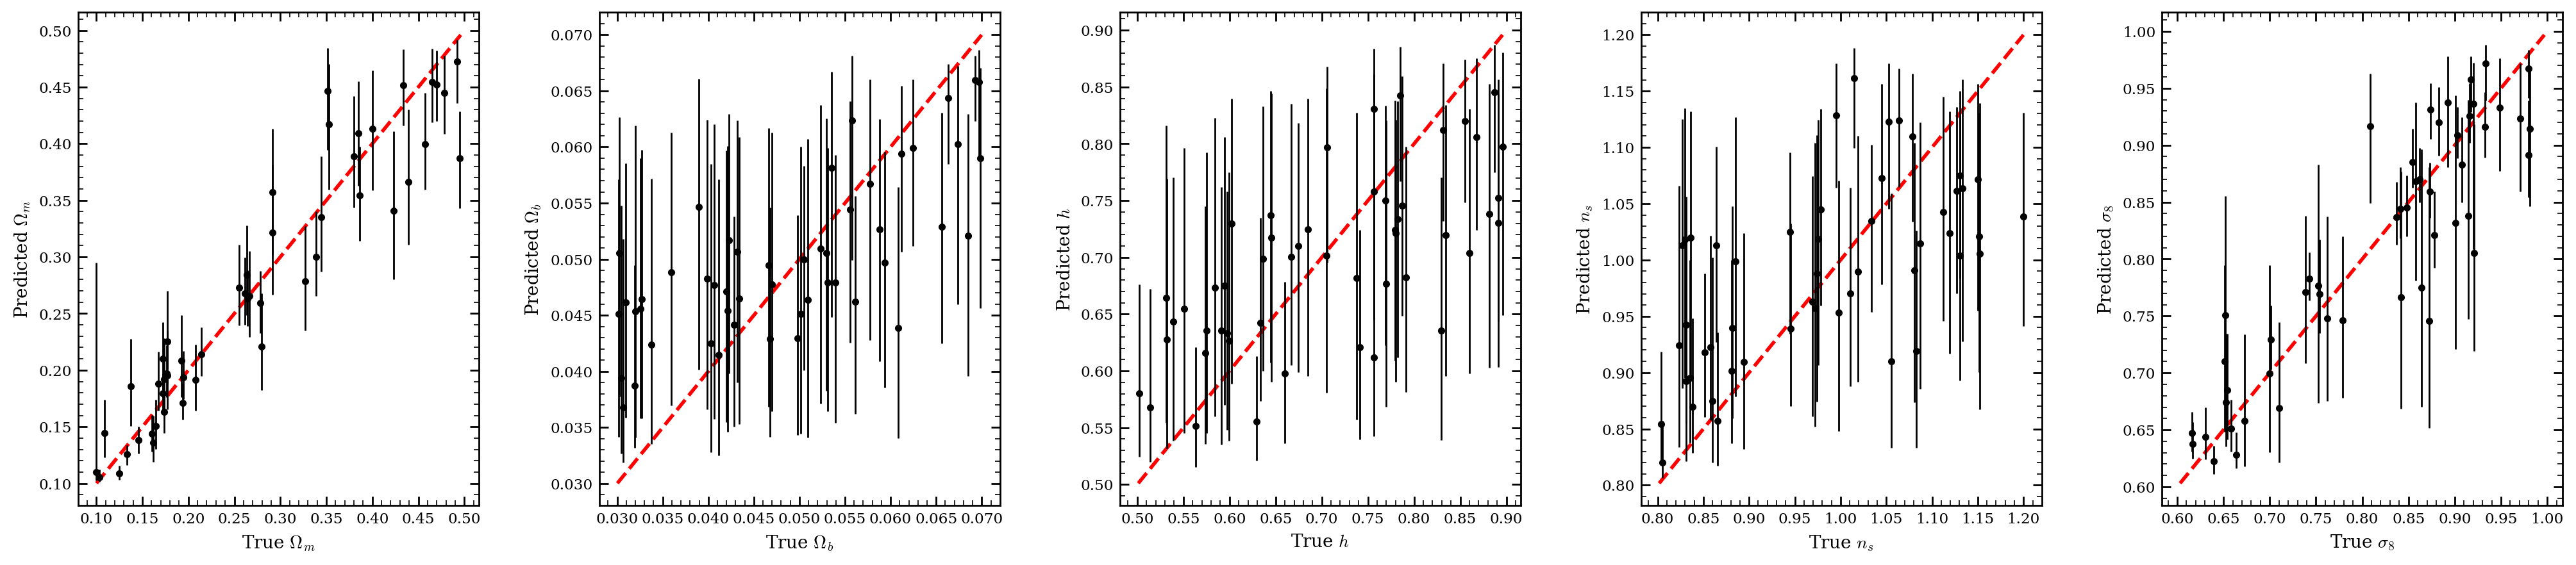

In [95]:
ss = 20

N = len(names)
H, W = N//5, 5
f, axs = plt.subplots(H, W, figsize=(5*W, 5*H), gridspec_kw=dict(wspace=0.3))
axs = axs.flatten()

for i, ax in enumerate(axs):
    if i >= N:
        ax.axis('off')
        continue
    ax.plot(yrange[i], yrange[i], 'r--')
    ax.plot(ytest[::ss, i], percs[1, ::ss, i], 'k.')
    ax.errorbar(ytest[::ss, i], percs[1, ::ss, i], yerr=[percs[1, ::ss, i]-percs[0, ::ss, i],
                percs[2, ::ss, i]-percs[1, ::ss, i]], fmt='none', ecolor='k', elinewidth=1)
    ax.set(xlabel=f'True {names[i]}', ylabel=f'Predicted {names[i]}')

In [96]:
from tools import load_posterior

posterior = load_posterior(modelpath)
for p in posterior.posteriors:
    print(type(p.nde.flow))

<class 'zuko.flows.spline.NSF'>
<class 'zuko.flows.spline.NSF'>
<class 'zuko.flows.spline.NSF'>
<class 'zuko.flows.spline.NSF'>
<class 'zuko.flows.spline.NSF'>
<class 'zuko.flows.spline.NSF'>
<class 'zuko.flows.spline.NSF'>
<class 'zuko.flows.spline.NSF'>
<class 'zuko.flows.spline.NSF'>
<class 'zuko.flows.spline.NSF'>


100%|██████████| 40/40 [00:00<00:00, 373.93it/s]


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Log Probability')]

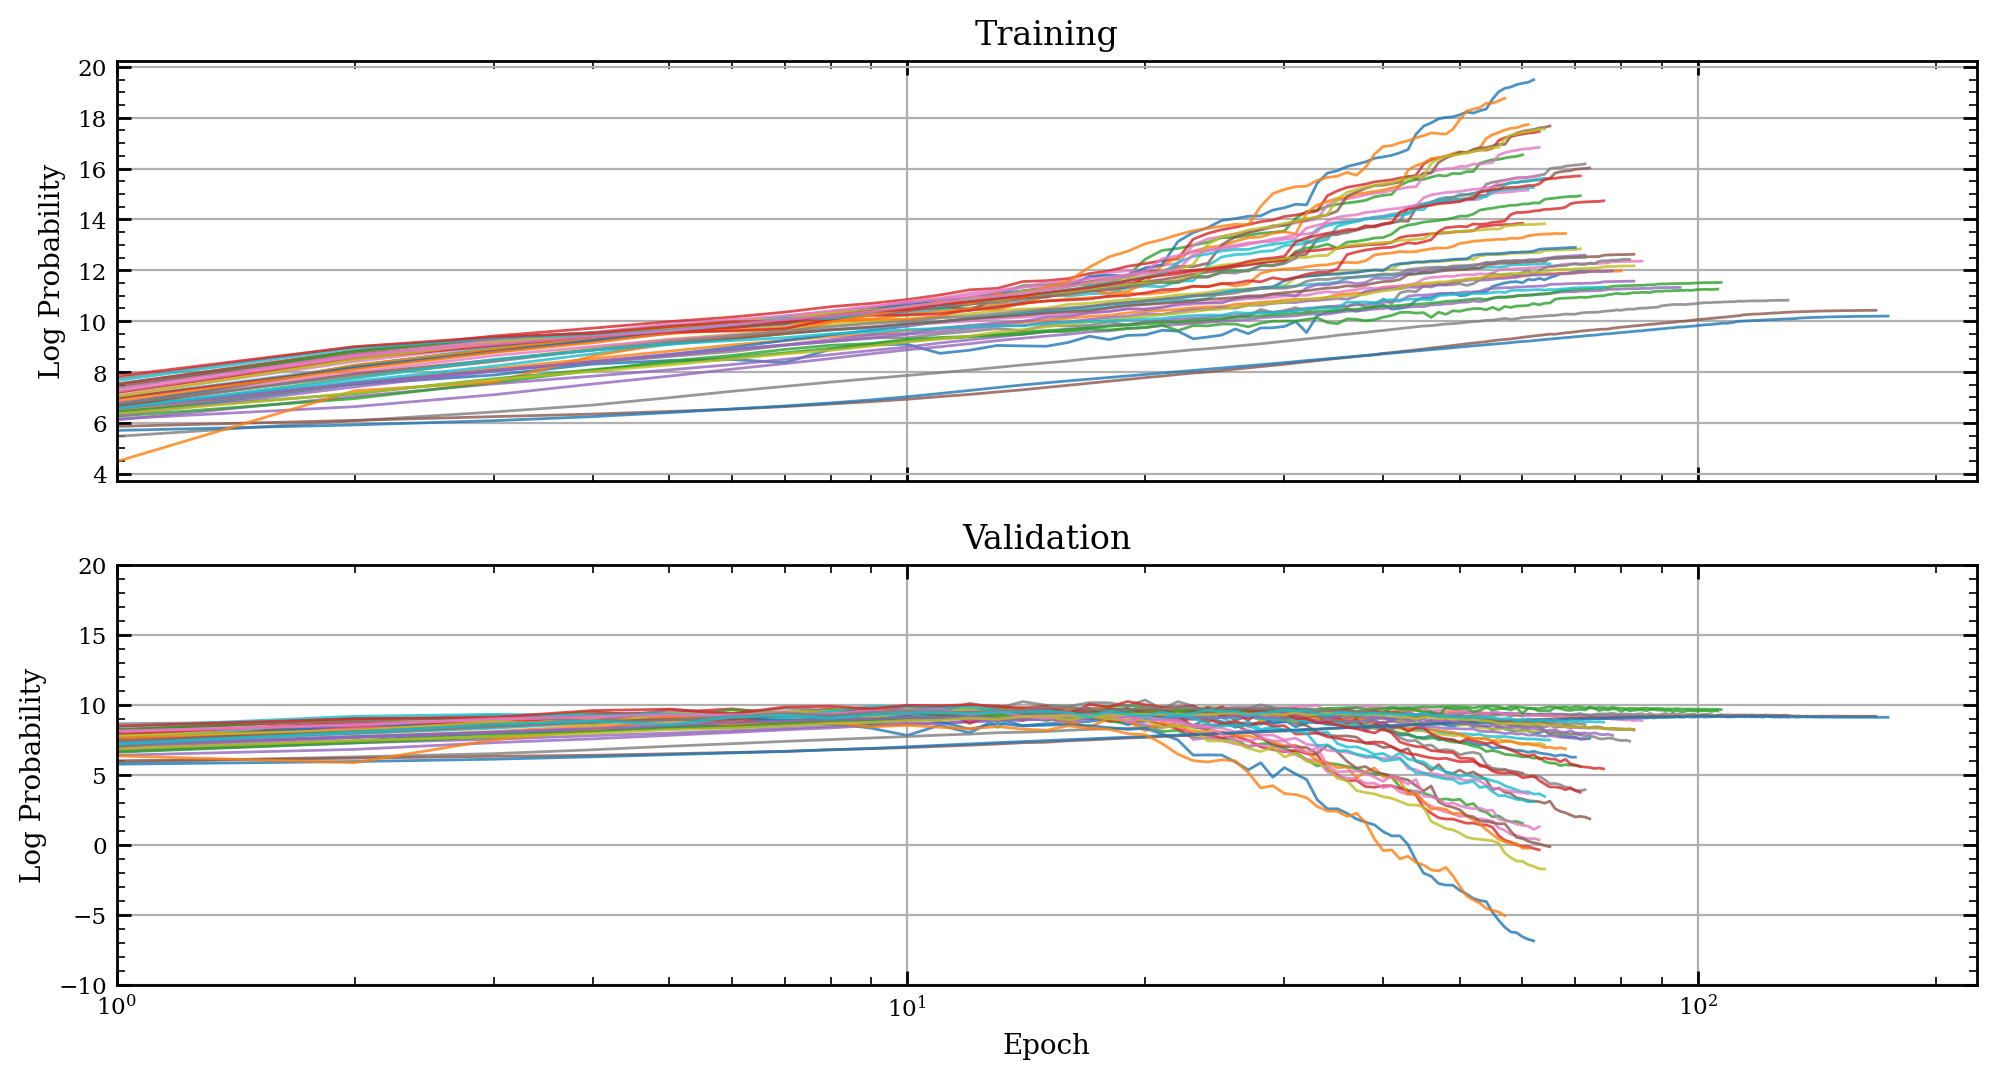

In [97]:
ss = 5

netpath = join(modelpath, 'nets')
netlist = os.listdir(netpath)

f, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

for n in tqdm(netlist[::ss]):
    filepath = join(netpath, n, 'summary.json')
    if not os.path.exists(filepath):
        continue
    with open(filepath, 'r') as f:
        history = json.load(f)

    x_ = range(1, len(history[0]['training_log_probs'])+1)

    ax = axs[0]
    ax.plot(x_, history[0]['training_log_probs'], alpha=0.8, lw=1)

    ax = axs[1]
    ax.plot(x_, history[0]['validation_log_probs'], alpha=0.8, lw=1)

ax.semilogx()
ax.set_xlim(1)
ax.set_ylim(-10, 20)

axs[0].set_title('Training')
axs[1].set_title('Validation')
axs[0].grid()
axs[1].grid()

axs[0].set(ylabel='Log Probability')
axs[1].set(xlabel='Epoch', ylabel='Log Probability')

INFO:root:Sampling models with [223, 207, 205, 202, 200, 199, 198, 193, 191, 189] samples each.
Drawing 223 posterior samples: 438it [00:00, 13634.95it/s]            
Drawing 207 posterior samples: 411it [00:00, 14415.83it/s]            
Drawing 205 posterior samples: 396it [00:00, 13150.89it/s]            
Drawing 202 posterior samples: 402it [00:00, 14057.71it/s]            
Drawing 200 posterior samples: 397it [00:00, 9554.94it/s]             
Drawing 199 posterior samples: 395it [00:00, 13329.18it/s]            
Drawing 198 posterior samples: 390it [00:00, 12420.87it/s]            
Drawing 193 posterior samples: 382it [00:00, 8178.45it/s]             
Drawing 191 posterior samples: 377it [00:00, 13904.79it/s]            
Drawing 189 posterior samples: 370it [00:00, 12841.90it/s]            


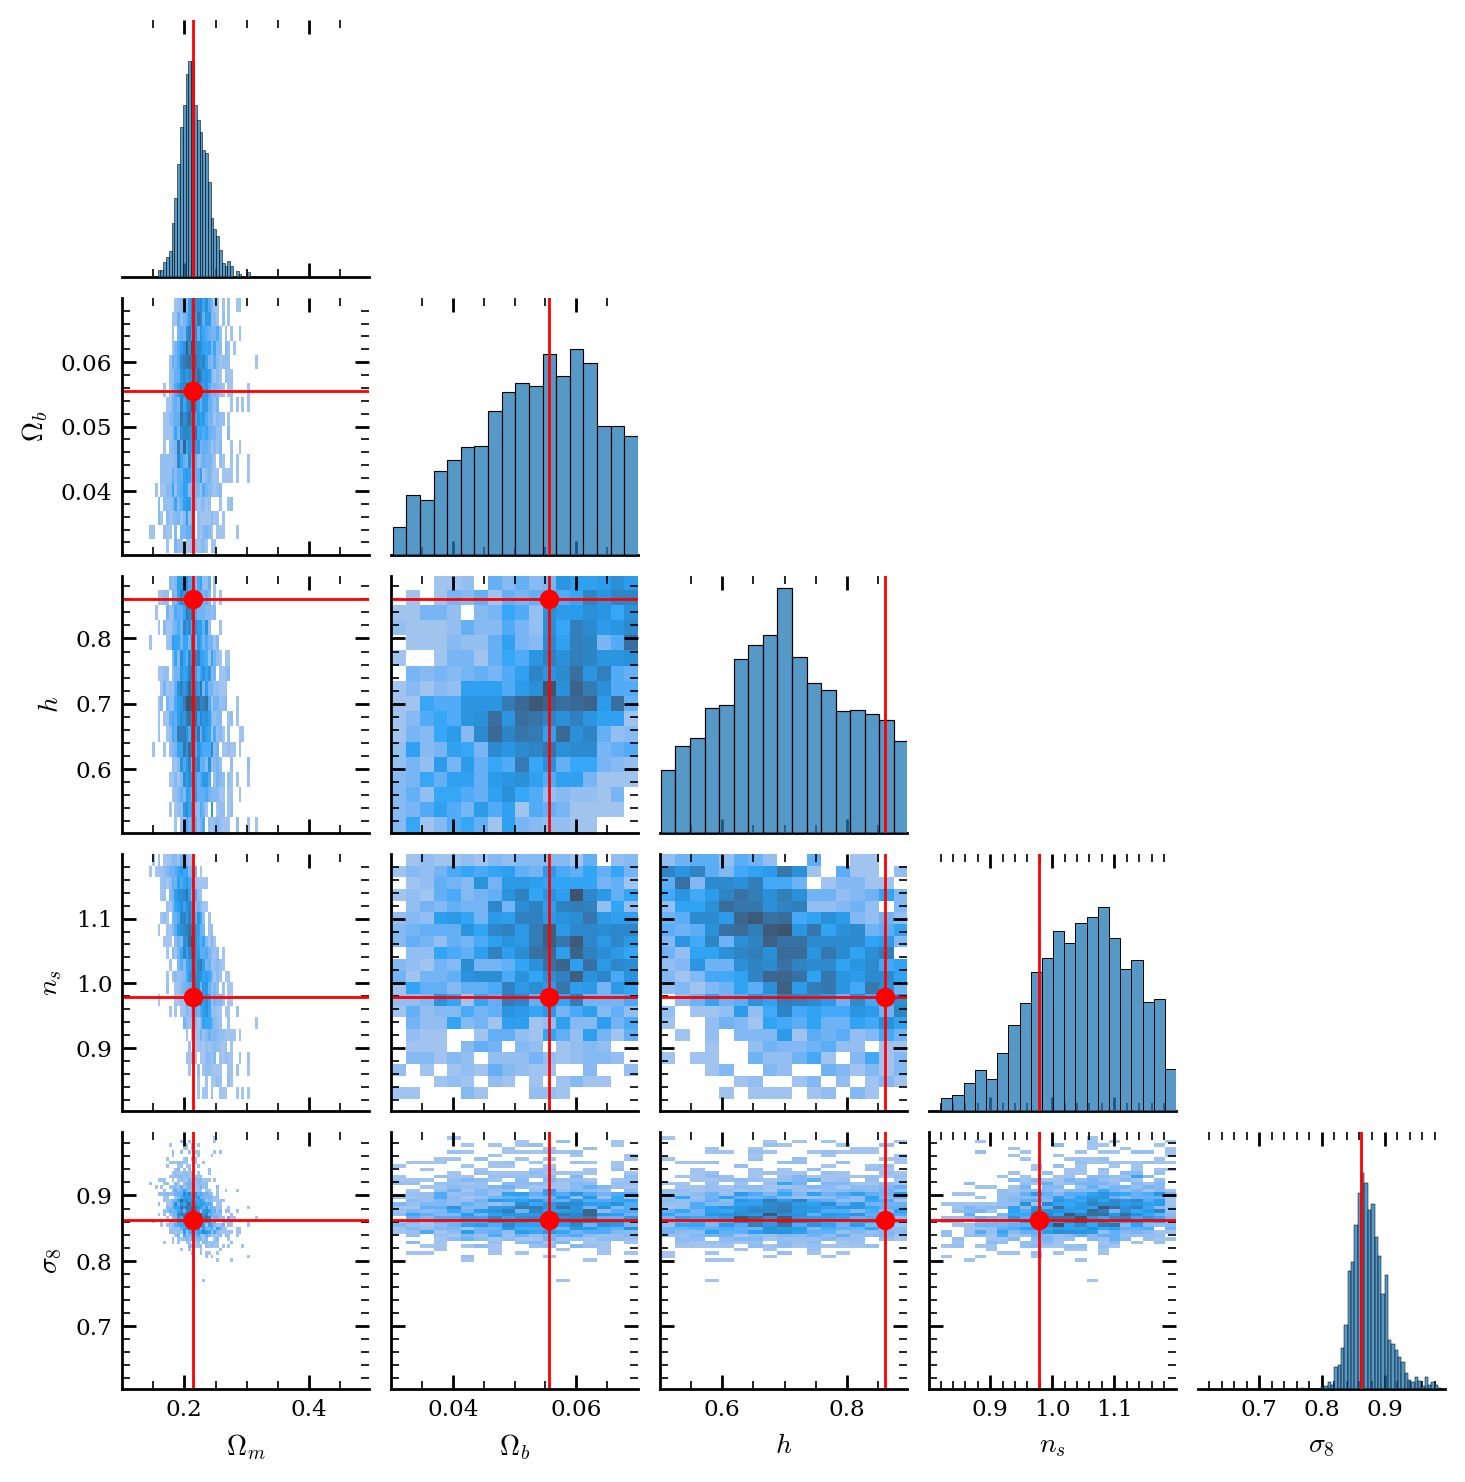

In [98]:
from tools import plot_true_vals, set_boundaries

# Predict on a random test point
ind = 0
x0 = torch.Tensor(xtest[ind]).to(device)
y0 = ytest[ind]
samp0 = posterior.sample(x=x0, shape=(2000,))
samp0 = pd.DataFrame(samp0, columns=names)

g = sns.pairplot(
    samp0,
    vars=names,
    kind='hist',
    corner=True,
    height=1.5
    # plot_kws={'alpha': 0.5, 'levels': [0.05, 0.36, 1], 'fill': True},  # for kde plot
)

plot_true_vals(g, y0, color='r', lw=1)
set_boundaries(g, yrange)

## Load an observed summary

In [99]:
# Load observed data
nbody = 'quijote'
sim = 'nonoise'
save_dir = join(wdir, nbody, sim, 'models')
modelpath = join(save_dir, tracer, summary, f'kmin-{kmin}_kmax-{kmax}')

xobs = np.load(join(modelpath, 'x_test.npy'))
yobs = np.load(join(modelpath, 'theta_test.npy'))
xid = np.load(join(modelpath, 'ids_test.npy'))

ss = 10
xobs = xobs[::ss]
yobs = yobs[::ss]
xid = xid[::ss]

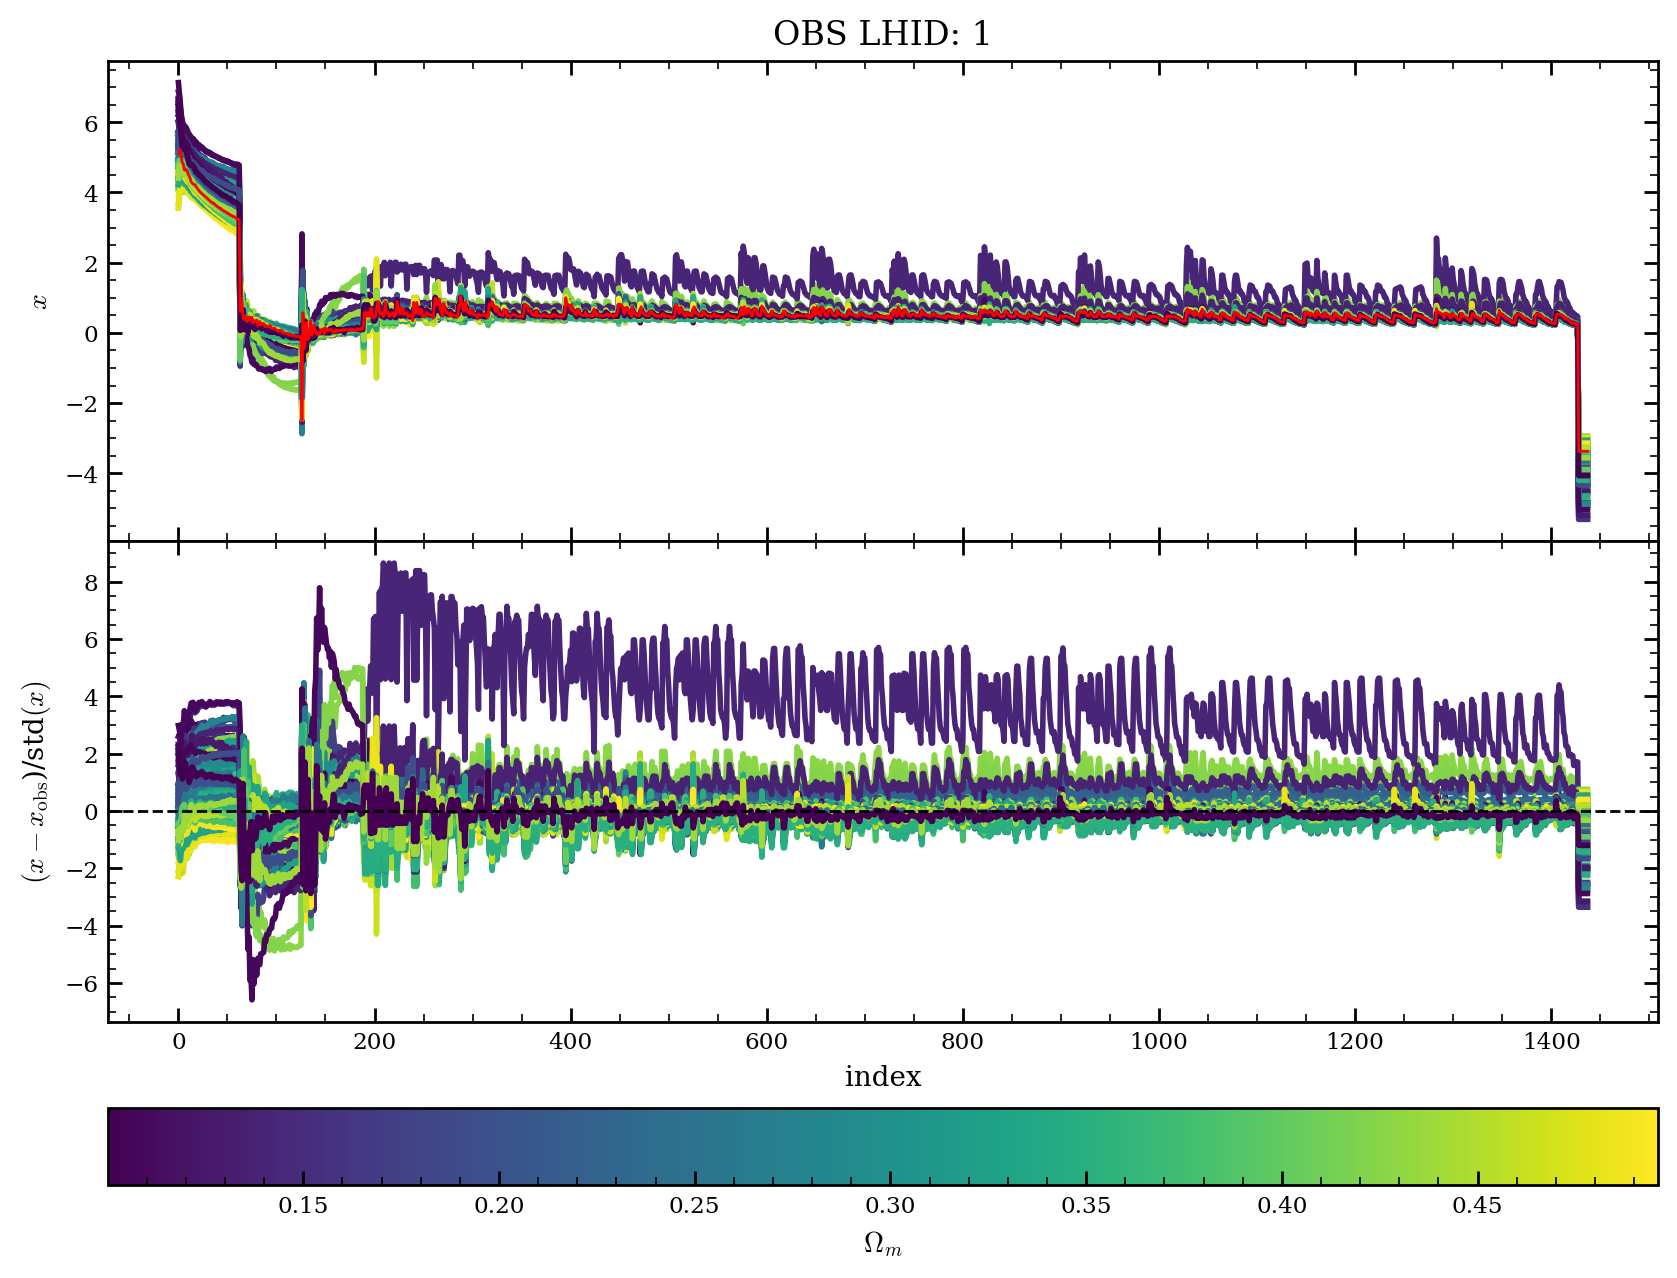

In [100]:
import matplotlib.colors as mcolors

ss = 10
ind = 0

f, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True,
                      gridspec_kw=dict(hspace=0., height_ratios=[1, 1]))

par = ytest[:, 0]
cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=par.min(), vmax=par.max())

ax = axs[0]
for i in range(0, len(xtest), ss):
    ax.plot(xtest[i], color=cmap(norm(par[i])))
ax.plot(xobs[ind], 'r-', lw=1)
ax.set(ylabel=r'$x$')
ax.set_title(f'OBS LHID: {xid[ind]}')

ax = axs[1]
for i in range(0, len(xtest), ss):
    ax.plot((xtest[i]-xobs[ind])/np.std(xtest, axis=0),
            color=cmap(norm(par[i])))
ax.axhline(0, c='k', ls='--', lw=1)
ax.set(xlabel='index', ylabel=r'$(x - x_{\rm obs}$)/std$(x)$')

cbar = f.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                  ax=axs, orientation='horizontal', pad=0.07)
cbar.set_label(r'$\Omega_m$')

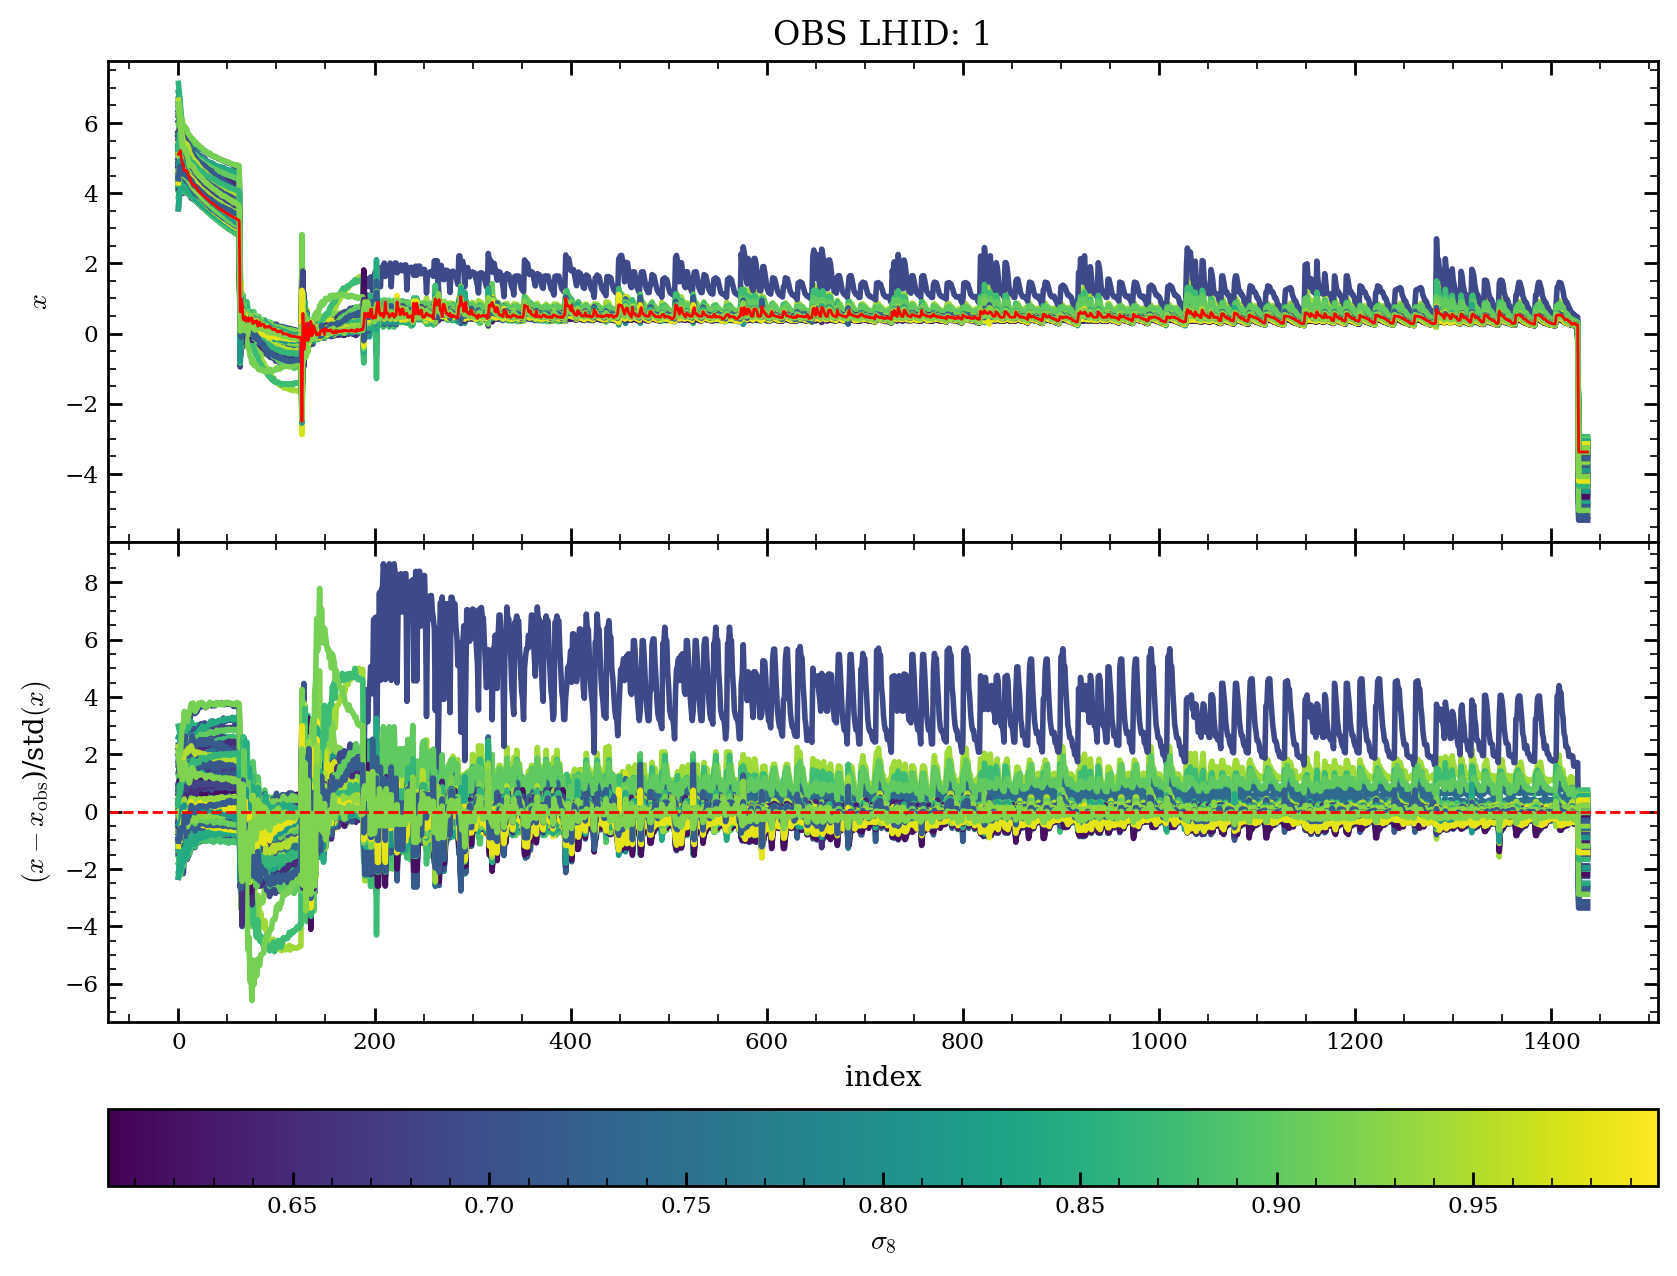

In [101]:
import matplotlib.colors as mcolors

ss = 10
ind = 0

f, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True,
                      gridspec_kw=dict(hspace=0., height_ratios=[1, 1]))

par = ytest[:, 4]
cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=par.min(), vmax=par.max())

ax = axs[0]
for i in range(0, len(xtest), ss):
    ax.plot(xtest[i], color=cmap(norm(par[i])))
ax.plot(xobs[ind], 'r-', lw=1)
ax.set(ylabel=r'$x$')
ax.set_title(f'OBS LHID: {xid[ind]}')

ax = axs[1]
for i in range(0, len(xtest), ss):
    ax.plot((xtest[i]-xobs[ind])/np.std(xtest, axis=0),
            color=cmap(norm(par[i])))
ax.axhline(0, c='r', ls='--', lw=1)
ax.set(xlabel='index', ylabel=r'$(x - x_{\rm obs}$)/std$(x)$')

cbar = f.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                  ax=axs, orientation='horizontal', pad=0.07)
cbar.set_label(r'$\sigma_8$')

INFO:root:Sampling models with [223, 207, 205, 202, 200, 199, 198, 193, 191, 189] samples each.
Drawing 223 posterior samples: 439it [00:00, 13069.24it/s]            
Drawing 207 posterior samples: 413it [00:00, 13664.60it/s]            
Drawing 205 posterior samples: 400it [00:00, 13348.73it/s]            
Drawing 202 posterior samples: 100%|██████████| 202/202 [00:00<00:00, 14069.47it/s]
Drawing 200 posterior samples: 395it [00:00, 9625.22it/s]             
Drawing 199 posterior samples: 392it [00:00, 13340.21it/s]            
Drawing 198 posterior samples: 395it [00:00, 13529.13it/s]            
Drawing 193 posterior samples: 383it [00:00, 8323.67it/s]             
Drawing 191 posterior samples: 378it [00:00, 14333.93it/s]            
Drawing 189 posterior samples: 100%|██████████| 189/189 [00:00<00:00, 13009.76it/s]


Text(0.5, 0.98, 'OBS LHID: 1, galaxy nbar+zPk0+zPk2+zPk4+zQk0, $k\\in[0.0,0.4]$,')

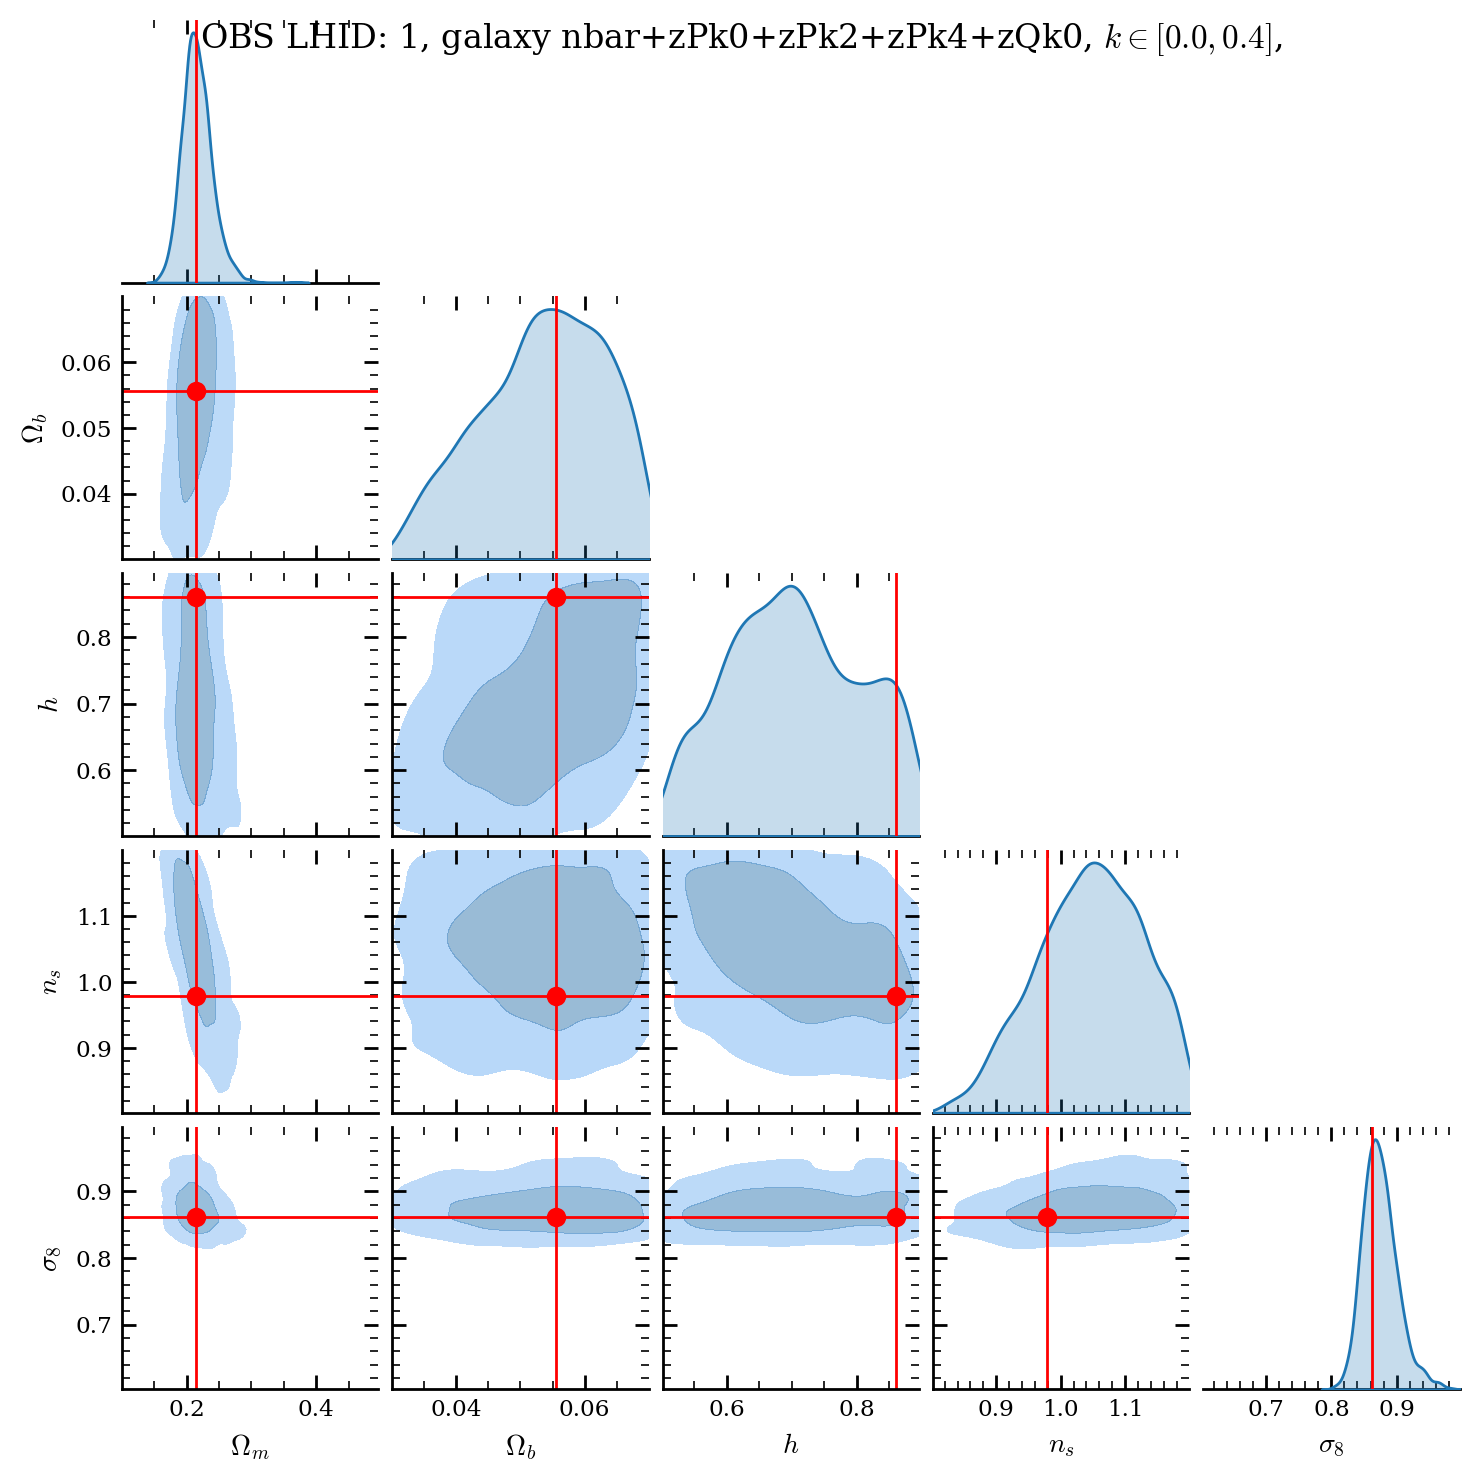

In [ ]:
from tools import plot_true_vals, set_boundaries

# Predict on a random test point
ind = 0
samp0 = posterior.sample(x=xobs[ind], shape=(2000,)).to('cpu')
samp0 = pd.DataFrame(samp0, columns=names)


g = sns.pairplot(
    samp0,
    vars=names,
    kind='kde',
    plot_kws={'alpha': 0.5, 'levels': [
        0.05, 0.36, 1], 'fill': True, 'common_norm': False},
    corner=True,
    height=1.5
)
plot_true_vals(g, yobs[ind], color='r', lw=1)
set_boundaries(g, yrange)

g.fig.suptitle(f'OBS LHID: {xid[ind]}, {tracer} ' +
               '+'.join(summaries) + f', $k\in[{kmin},{kmax}]$,')

## Predict on a suite of summaries

In [106]:
samps = []
for xin in tqdm(xobs):
    samp = posterior.sample(x=xin, shape=(
        1000,), show_progress_bars=False).to('cpu')
    samps.append(samp)
samps = np.array(samps)
trues = np.array(yobs)

100%|██████████| 99/99 [00:25<00:00,  3.84it/s]


Text(0.5, 0.98, 'galaxy nbar+zPk0+zPk2+zPk4+zQk0, $k\\in[0.0,0.4]$,')

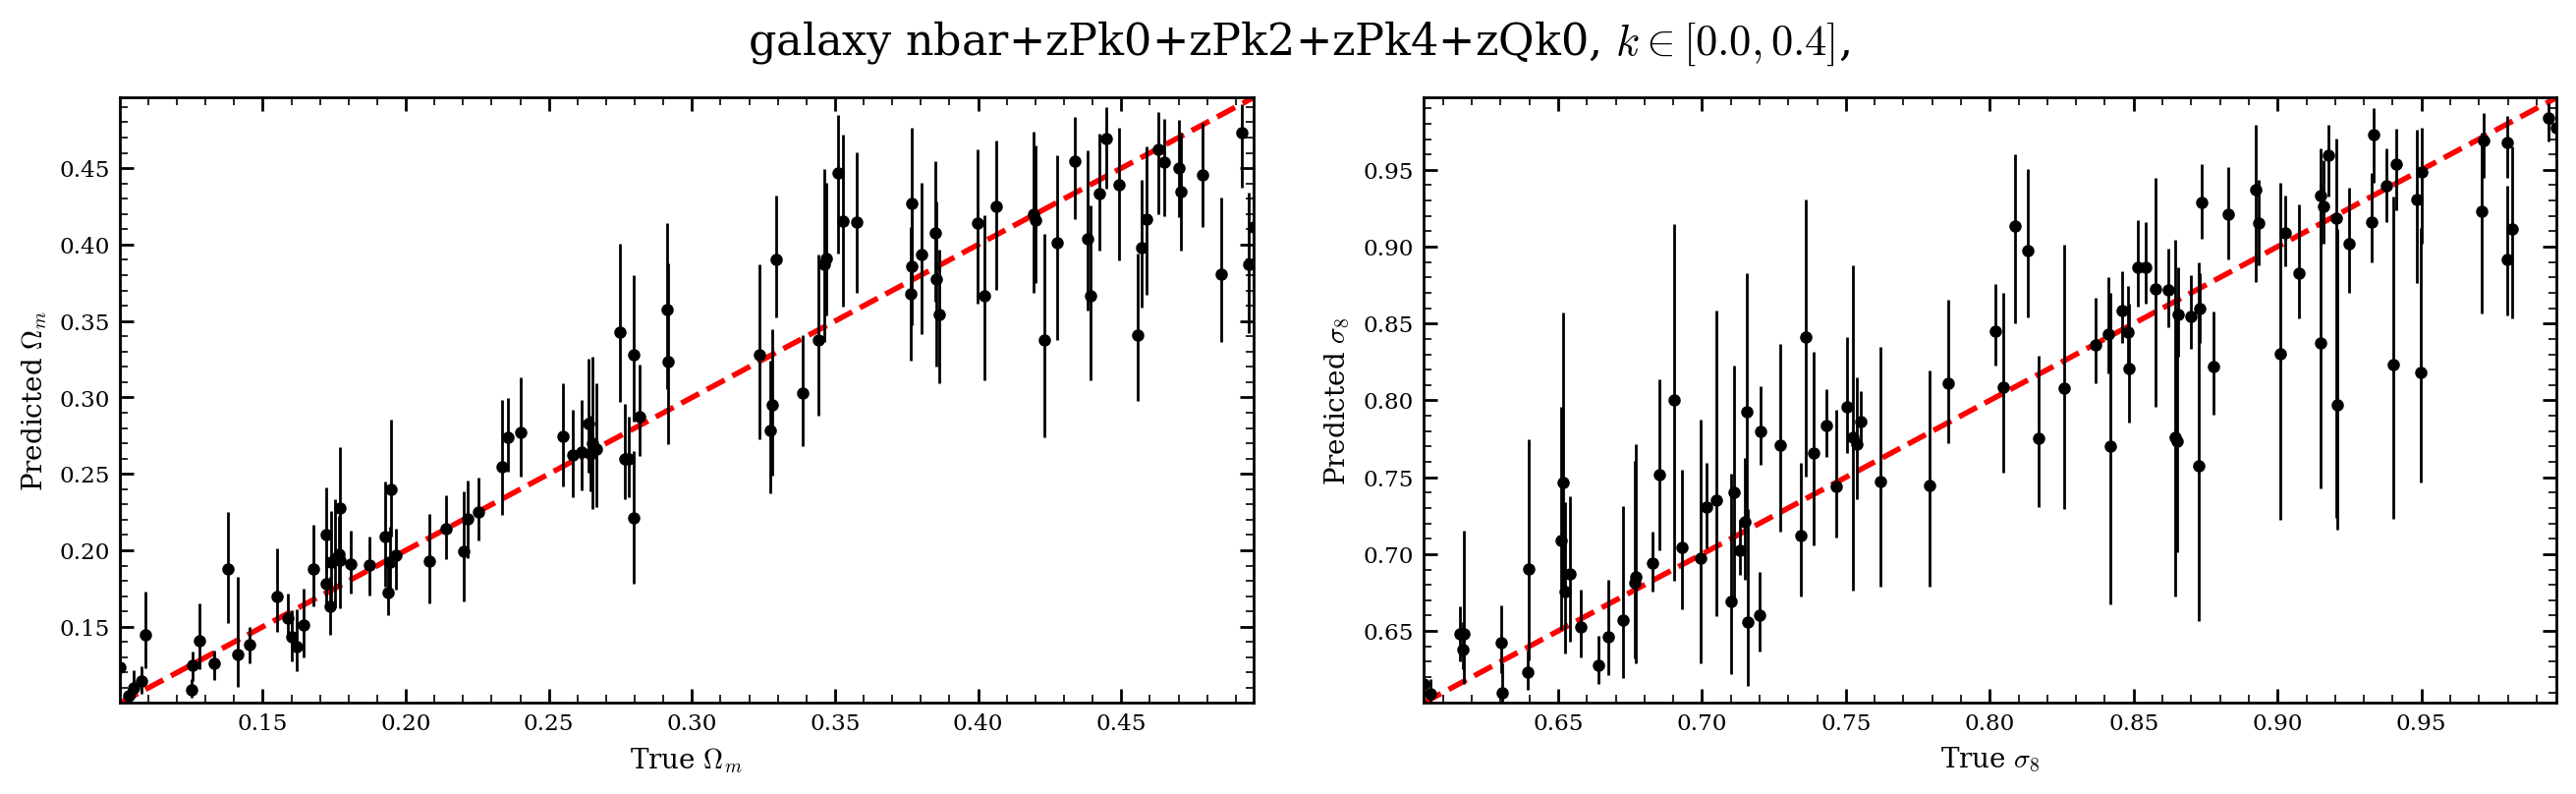

In [107]:
# Plot Om-s8

H, W = 1, 2
f, axs = plt.subplots(H, W, figsize=(8*W, 4*H), gridspec_kw=dict(wspace=0.15))
axs = axs.flatten()

for j, i in enumerate([0, 4]):
    ax = axs[j]
    ax.plot(yrange[i], yrange[i], 'r--')
    ax.set_xlim(yrange[i])
    ax.set_ylim(yrange[i])
    ax.set(xlabel=f'True {names[i]}', ylabel=f'Predicted {names[i]}')

    percs = np.percentile(samps[..., i], [50, 16, 84], axis=1)
    ax.plot(trues[:, i], percs[0], '.',
            c='k', markersize=7)
    ax.errorbar(trues[:, i], percs[0], yerr=[percs[0]-percs[1], percs[2]-percs[0]],
                c='k', fmt='none', elinewidth=1)
    # ax.legend()

f.suptitle(
    f'{tracer} ' + '+'.join(summaries) + f', $k\in[{kmin},{kmax}]$,',
    fontsize=16)

Text(0.5, 0.98, 'galaxy nbar+zPk0+zPk2+zPk4+zQk0, $k\\in[0.0,0.4]$,')

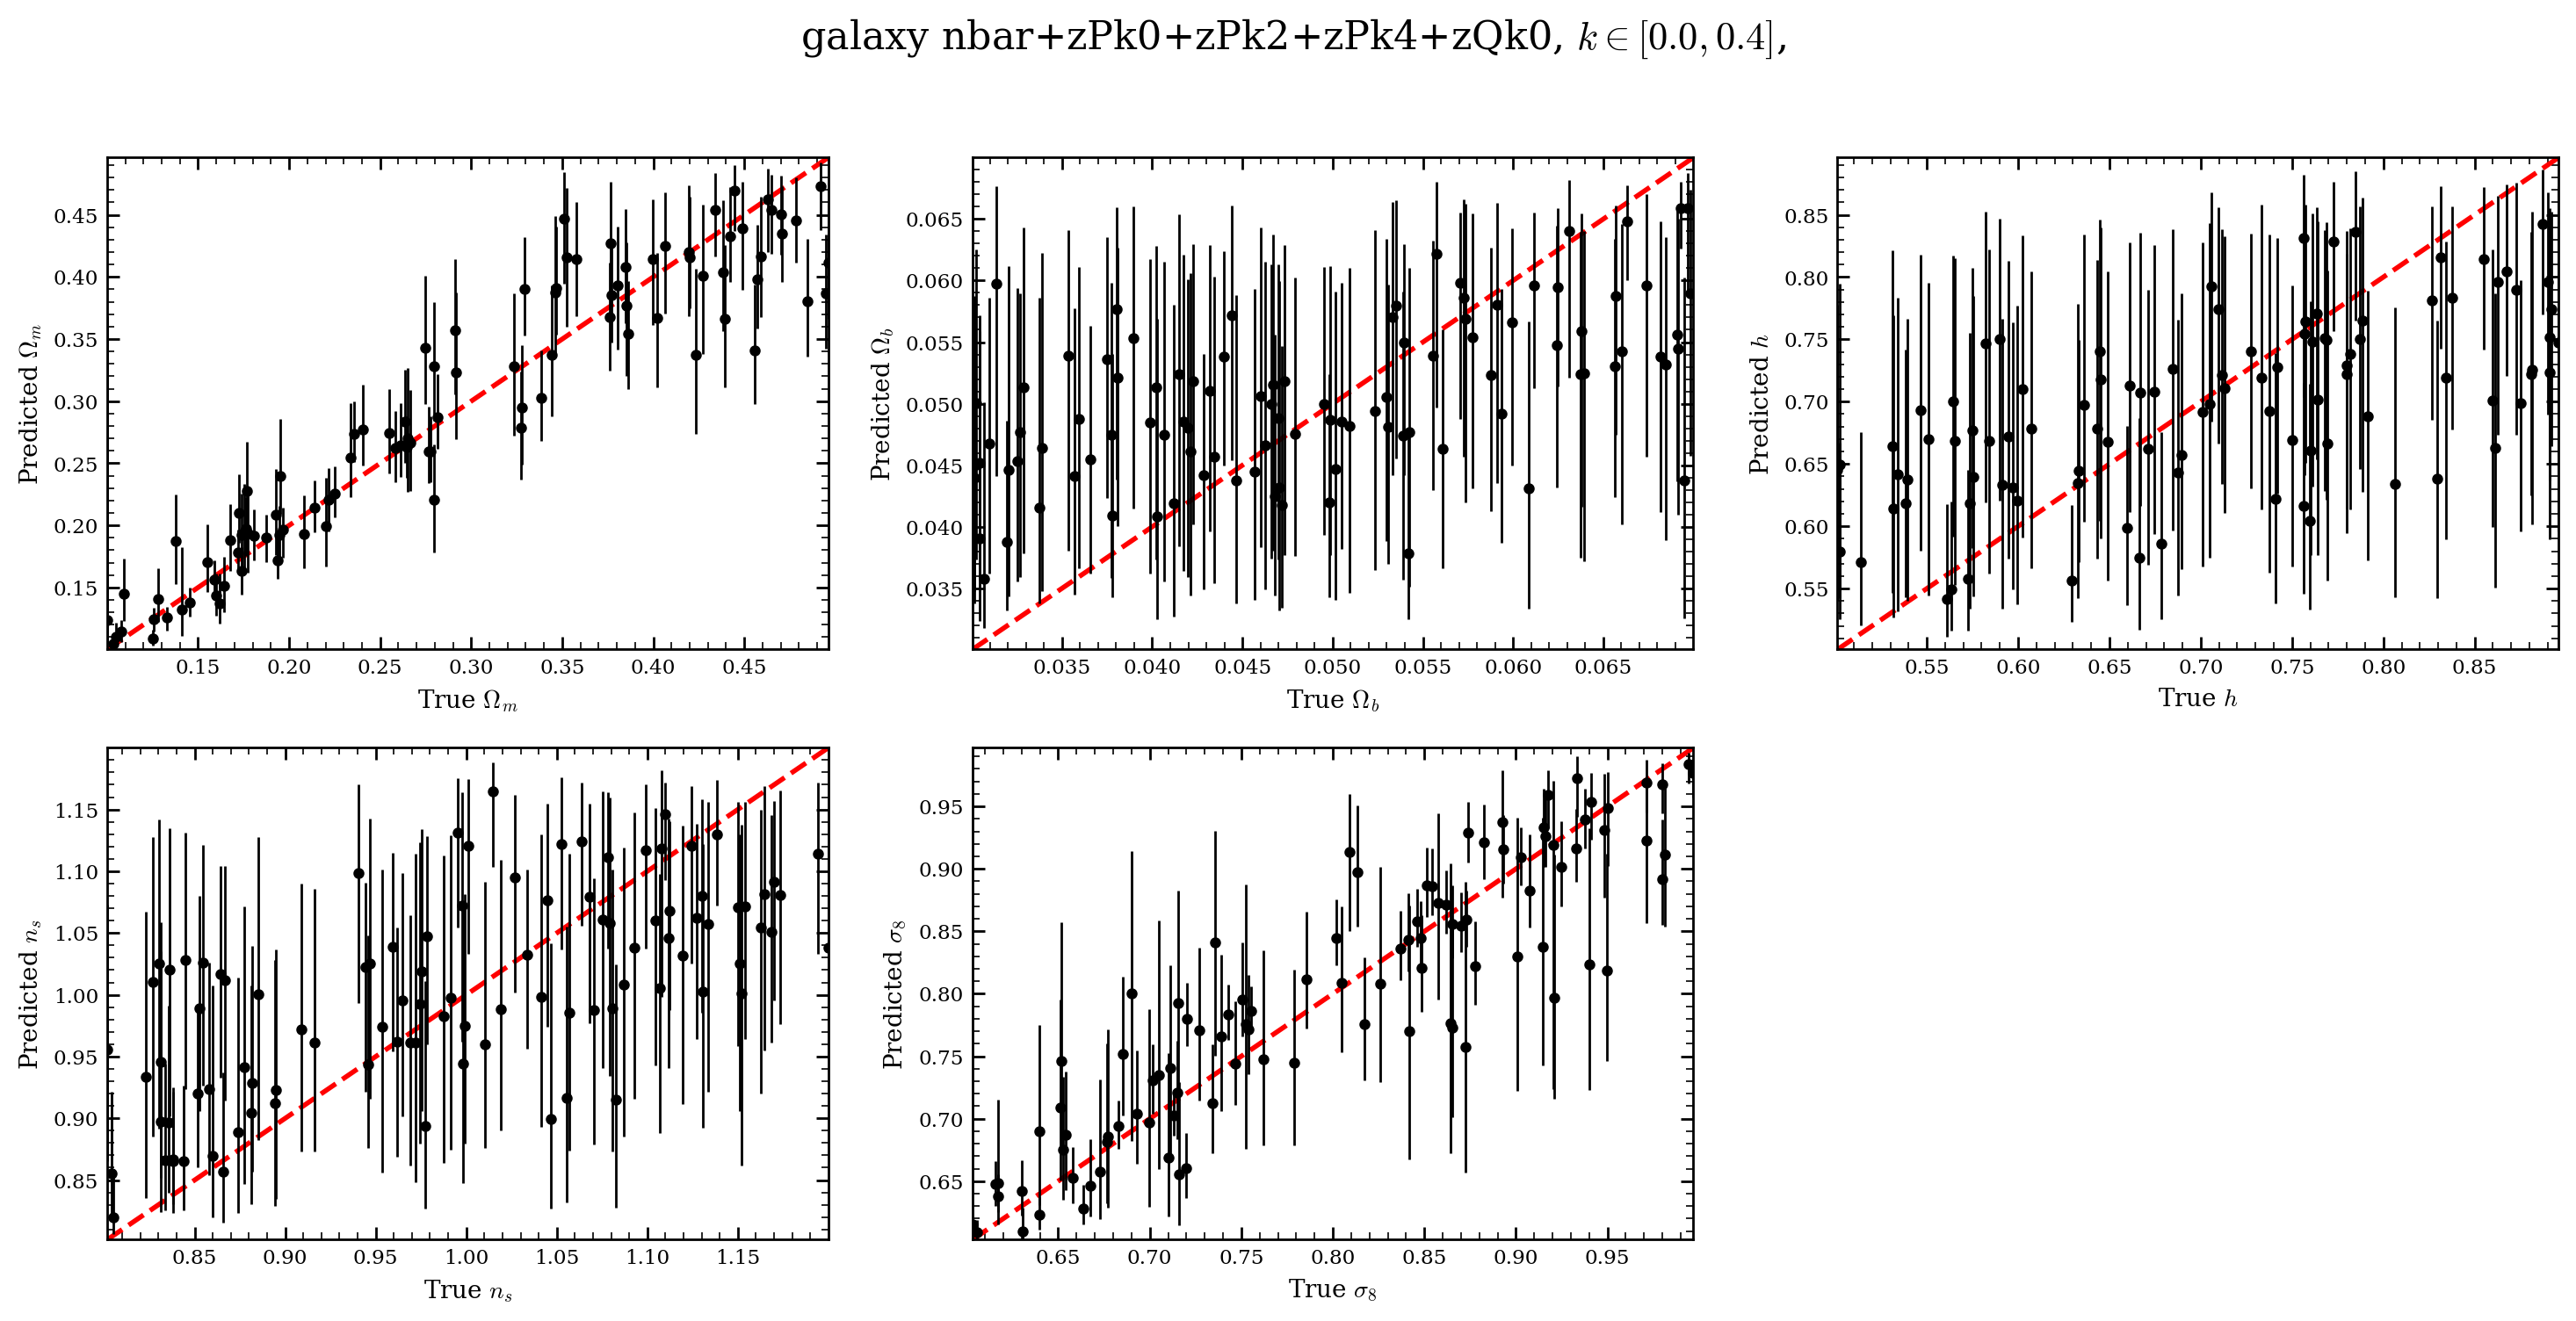

In [108]:
# Plot Om-s8

H, W = 2, 3
f, axs = plt.subplots(H, W, figsize=(6*W, 4*H),
                      gridspec_kw=dict(wspace=0.2))
axs = axs.flatten()

for i in range(5):
    j = i
    ax = axs[j]
    ax.plot(yrange[i], yrange[i], 'r--')
    ax.set_xlim(yrange[i])
    ax.set_ylim(yrange[i])
    ax.set(xlabel=f'True {names[i]}', ylabel=f'Predicted {names[i]}')

    percs = np.percentile(samps[..., i], [50, 16, 84], axis=1)
    ax.plot(trues[:, i], percs[0], '.',
            c='k', markersize=7)
    ax.errorbar(trues[:, i], percs[0], yerr=[percs[0]-percs[1], percs[2]-percs[0]],
                c='k', fmt='none', elinewidth=1)
    # ax.legend()

for j in range(i+1, H*W):
    ax = axs[j]
    ax.axis('off')

f.suptitle(
    f'{tracer} ' + '+'.join(summaries) + f', $k\in[{kmin},{kmax}]$,',
    fontsize=16)

## Compare to literature

In [109]:
# Load literature data
lit_path = join(wdir, 'literature', 'processed')

# SimBIG zPk024
filename = join(lit_path, 'simbig_pk.csv')
simpk = pd.read_csv(filename)
simpk.columns = names
simpk['Model'] = 'SimBIG zPk024'

# SimBIG zQk0
filename = join(lit_path, 'simbig_bk.csv')
simbk = pd.read_csv(filename)
simbk.columns = names
simbk['Model'] = 'SimBIG zQk0'

print(simpk.shape, simbk.shape)

(2000, 6) (2000, 6)


INFO:root:Sampling models with [223, 207, 205, 202, 200, 199, 198, 193, 191, 189] samples each.
Drawing 223 posterior samples: 433it [00:00, 13684.88it/s]            
Drawing 207 posterior samples: 100%|██████████| 207/207 [00:00<00:00, 12379.11it/s]
Drawing 205 posterior samples: 405it [00:00, 13231.66it/s]            
Drawing 202 posterior samples: 397it [00:00, 13659.87it/s]            
Drawing 200 posterior samples: 397it [00:00, 9481.00it/s]             
Drawing 199 posterior samples: 387it [00:00, 13226.07it/s]            
Drawing 198 posterior samples: 100%|██████████| 198/198 [00:00<00:00, 13046.46it/s]
Drawing 193 posterior samples: 380it [00:00, 7961.30it/s]             
Drawing 191 posterior samples: 381it [00:00, 14129.60it/s]            
Drawing 189 posterior samples: 375it [00:00, 12805.31it/s]            


Text(0.5, 0.98, 'OBS LHID: 198, galaxy nbar+zPk0+zPk2+zPk4+zQk0, $k\\in[0.0,0.4]$,')

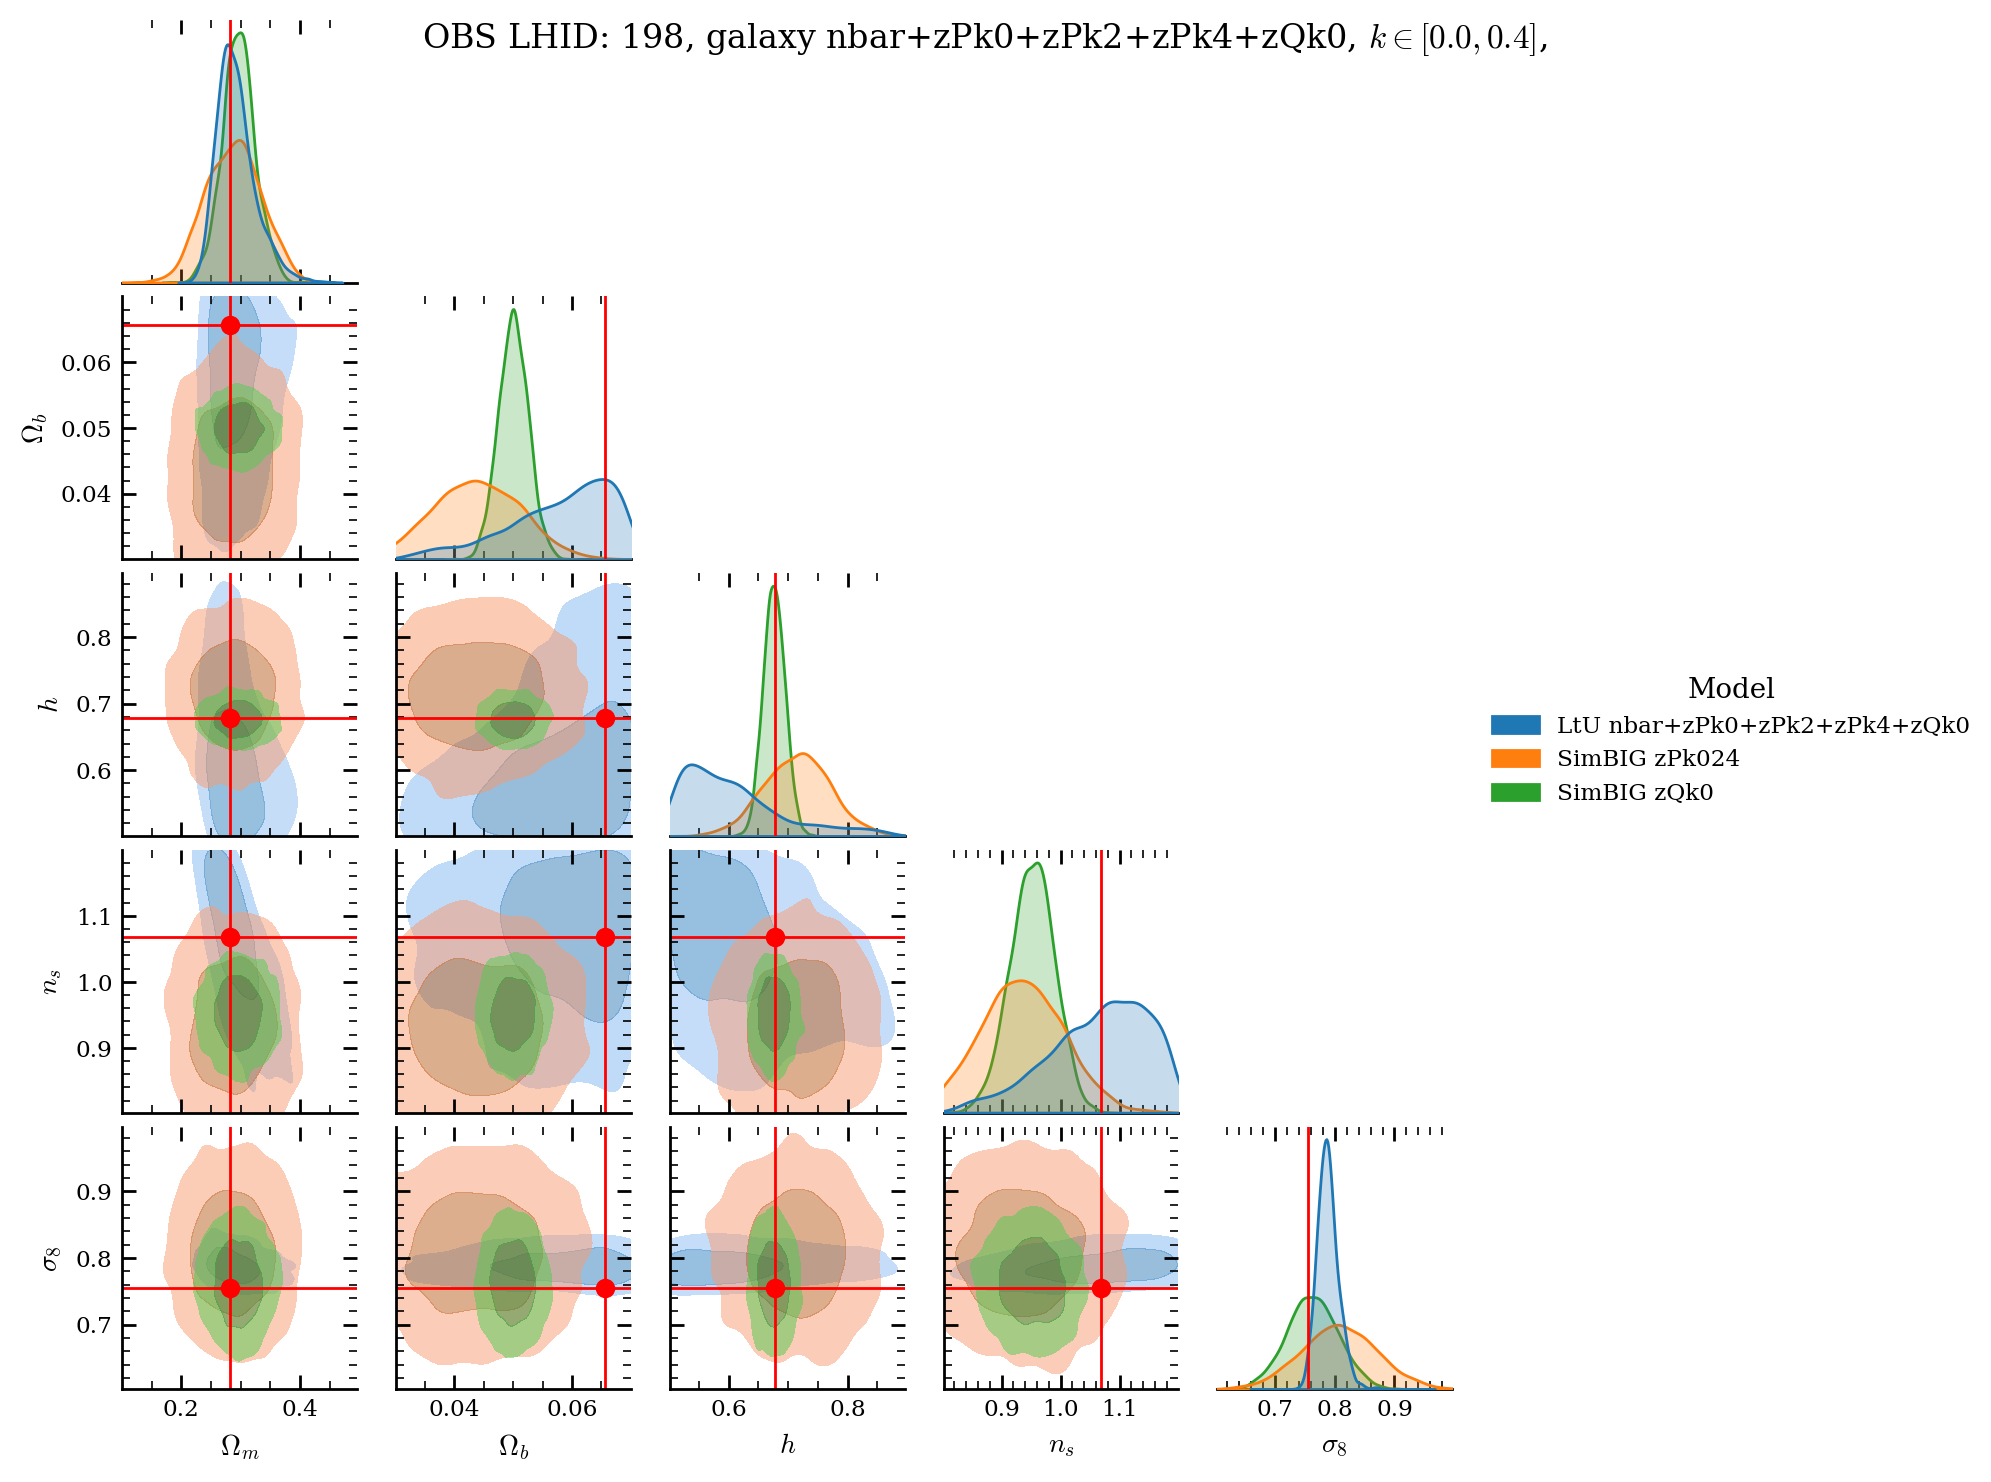

In [110]:
from tools import plot_true_vals, set_boundaries

# Predict on a random test point
ind = 11
samp0 = posterior.sample(x=xobs[ind], shape=(2000,)).to('cpu')
samp0 = pd.DataFrame(samp0, columns=names)
samp0['Model'] = f'LtU {summary}'
samp0 = pd.concat([samp0, simpk, simbk], ignore_index=True)

g = sns.pairplot(
    samp0,
    hue='Model',
    vars=names,
    kind='kde',
    plot_kws={'alpha': 0.5, 'levels': [
        0.05, 0.36, 1], 'fill': True, 'common_norm': False},
    corner=True,
    height=1.5
)
set_boundaries(g, yrange)
plot_true_vals(g, yobs[ind], color='r', lw=1)

g.fig.suptitle(f'OBS LHID: {xid[ind]}, {tracer} ' +
               '+'.join(summaries) + f', $k\in[{kmin},{kmax}]$,')

Text(0.5, 0.98, 'galaxy nbar+zPk0+zPk2+zPk4+zQk0, $k\\in[0.0,0.4]$,')

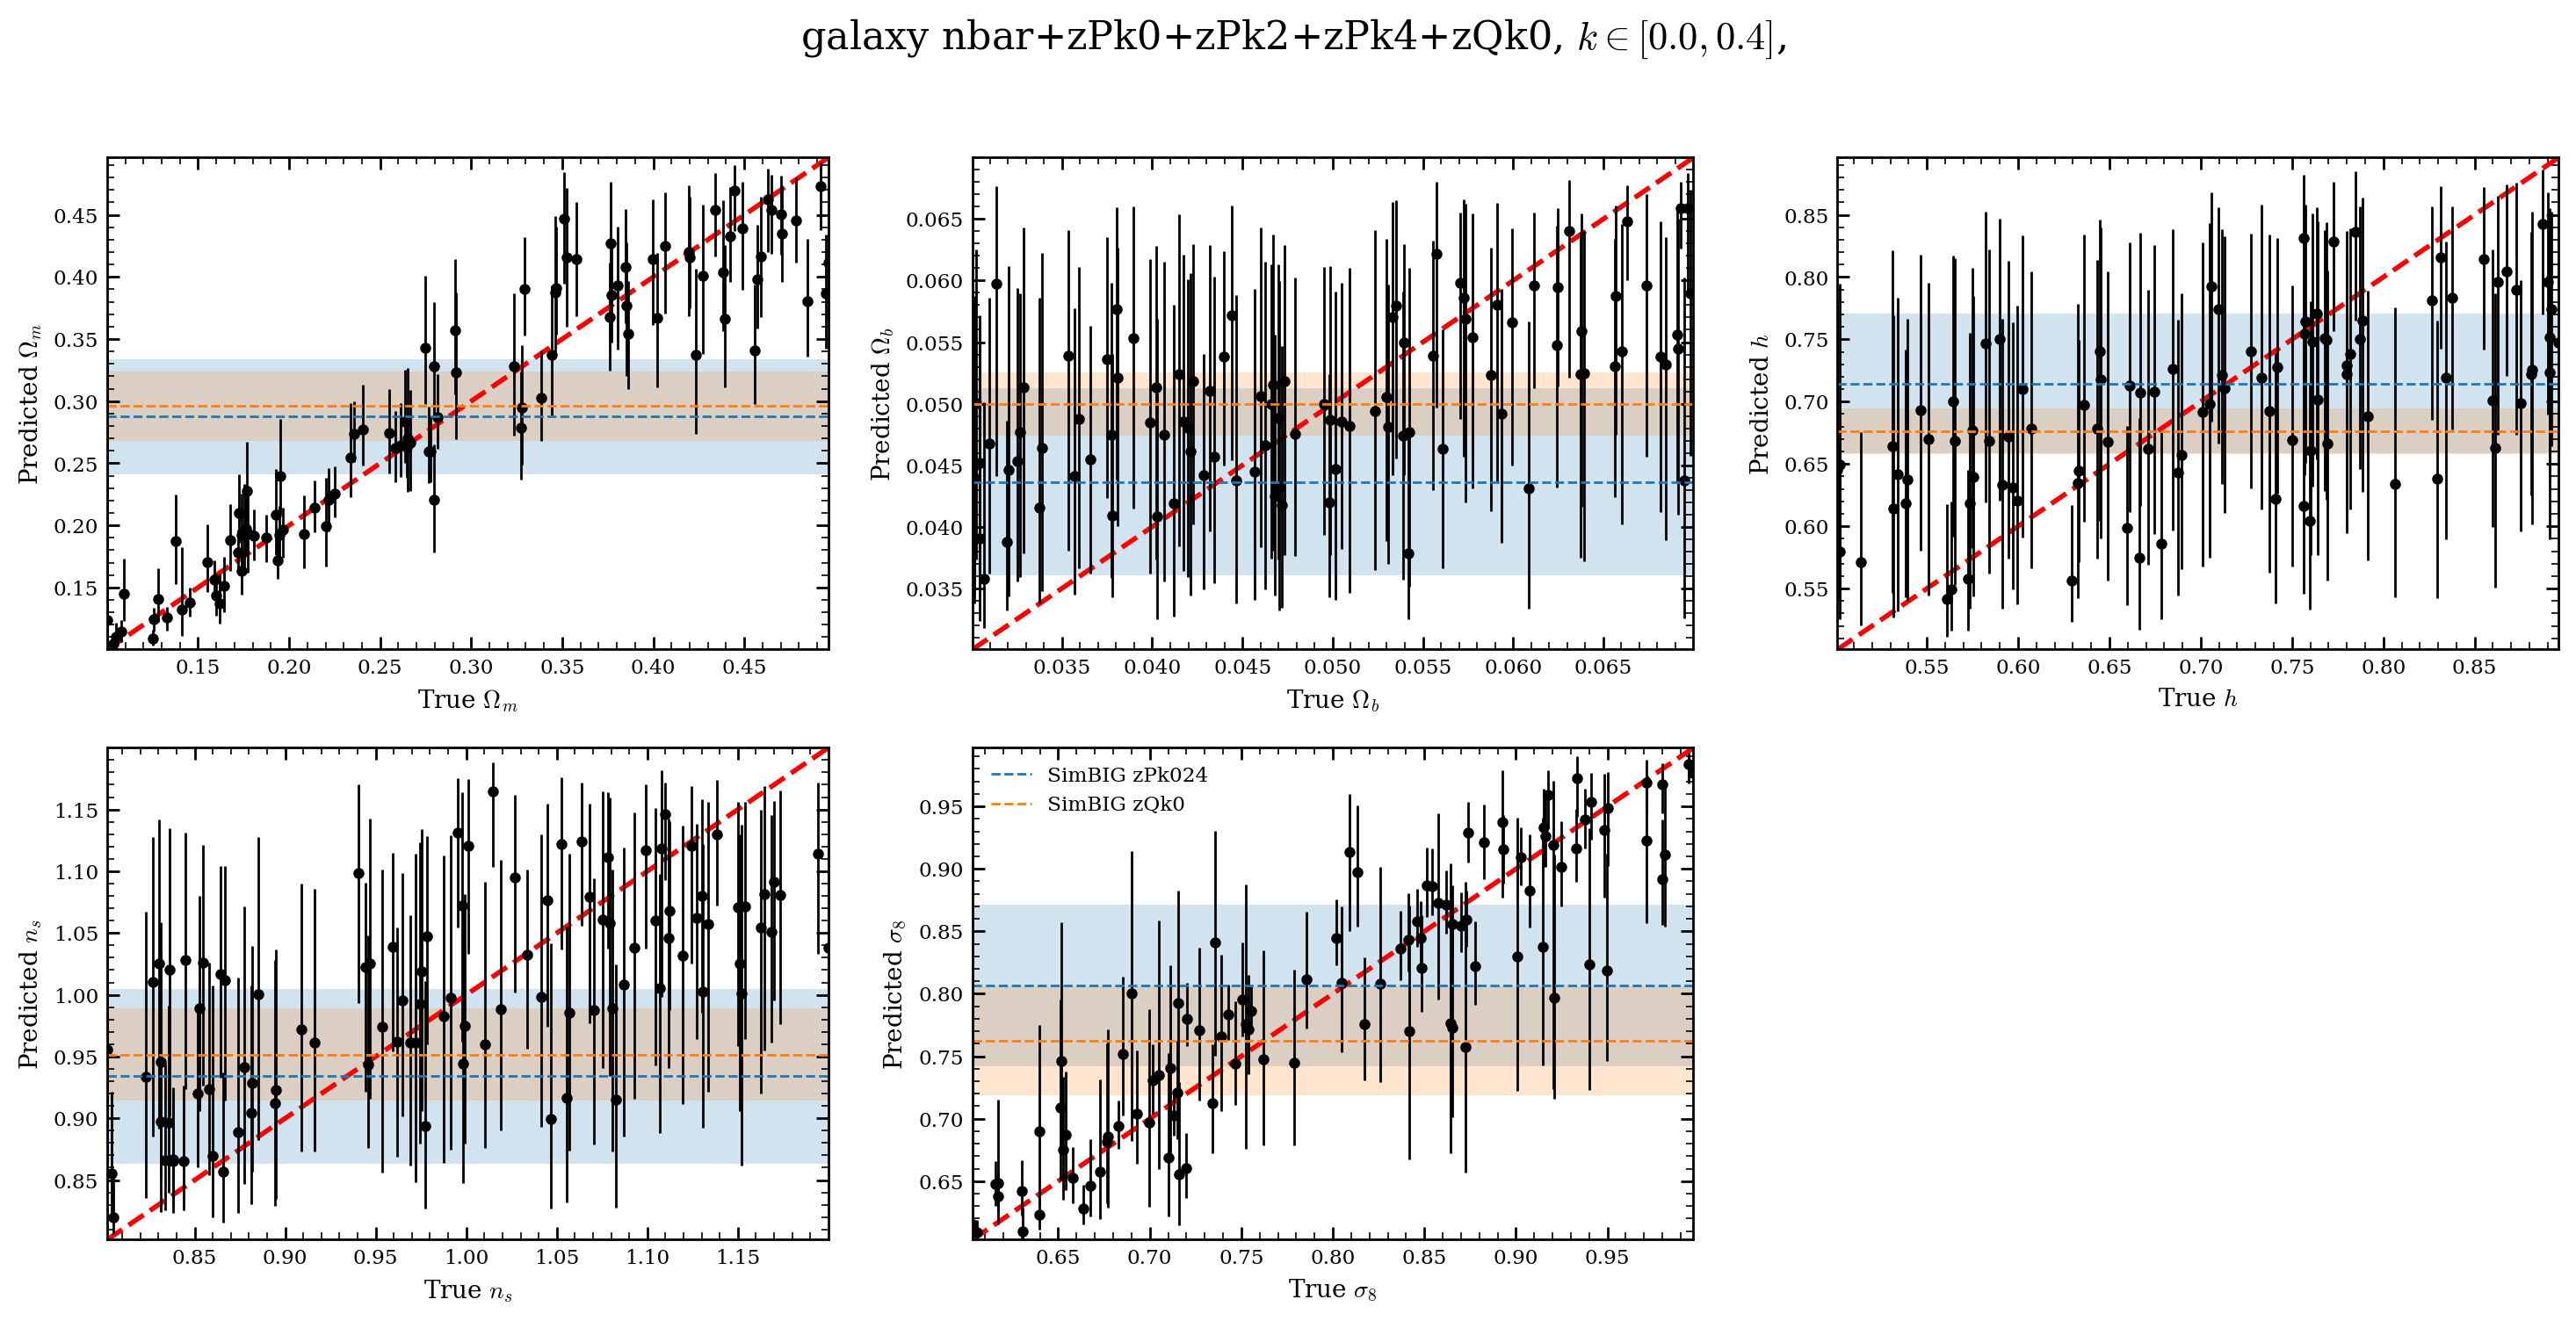

In [111]:
# Plot Om-s8

H, W = 2, 3
f, axs = plt.subplots(H, W, figsize=(6*W, 4*H),
                      gridspec_kw=dict(wspace=0.2))
axs = axs.flatten()

for i in range(5):
    j = i
    ax = axs[j]
    ax.plot(yrange[i], yrange[i], 'r--')
    ax.set_xlim(yrange[i])
    ax.set_ylim(yrange[i])
    ax.set(xlabel=f'True {names[i]}', ylabel=f'Predicted {names[i]}')

    percs = np.percentile(samps[..., i], [50, 16, 84], axis=1)
    ax.plot(trues[:, i], percs[0], '.',
            c='k', markersize=7)
    ax.errorbar(trues[:, i], percs[0], yerr=[percs[0]-percs[1], percs[2]-percs[0]],
                c='k', fmt='none', elinewidth=1)
    # plot literature data
    for k, l in enumerate([simpk, simbk]):
        loc, scale = l[names[i]].mean(), l[names[i]].std()
        ax.axhline(loc, c=f'C{k}', ls='--', lw=1, label=l['Model'].iloc[0])
        ax.fill_between(
            [yrange[i][0], yrange[i][1]], loc-scale, loc+scale,
            color=f'C{k}', alpha=0.2, lw=0)

ax.legend()

for j in range(i+1, H*W):
    ax = axs[j]
    ax.axis('off')

f.suptitle(
    f'{tracer} ' + '+'.join(summaries) + f', $k\in[{kmin},{kmax}]$,',
    fontsize=16)